# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "E:/AV/DataSetExploration/drone-dataset-tools/data/location-2/home"
dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2/lab"
# dataDir = "/home/office/AV/DataSetExploration/data/ind/location-2/csv"

In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\DataSetExploration\TTI-dataset-tools\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper
from ind_tools.IndTransformer import IndTransformer
from tti_dataset_tools import CrosswalkModel

In [5]:

date = "2022-12-22"
fps=5
maxXDisplacement = 9

sceneDisplacementMap = {
    21: 8,
    22: 8,
    31: 5
}

sceneRoadWidth = {
    21: 9,
    22: 9,
    31: 6,
    11: 6
}

    

In [7]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        fps=fps,
    )
transformer = TrajectoryTransformer(colMapper)
indTransformer = IndTransformer(colMapper)
crosswalkModel = CrosswalkModel(colMapper)

Processing scene #21
using min Y displacement (8)


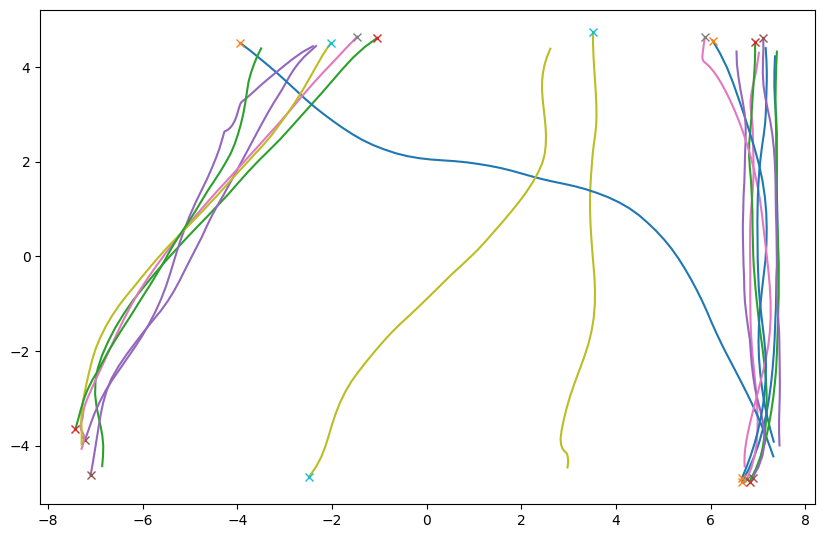

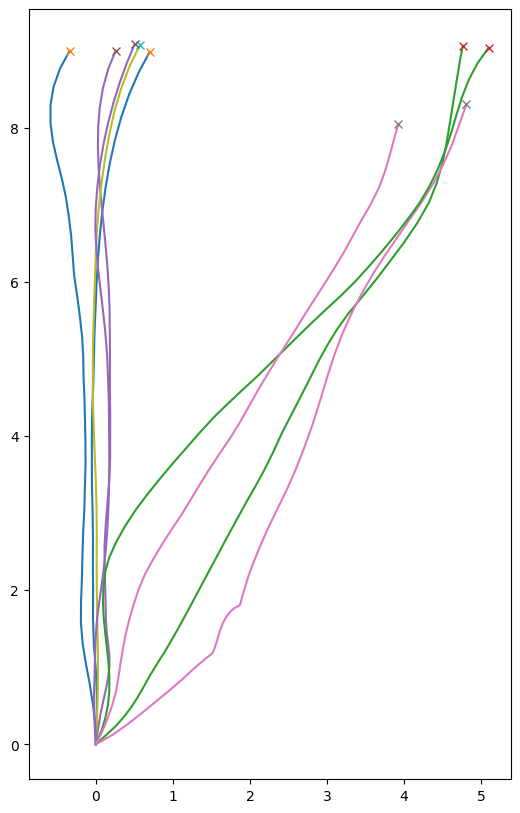

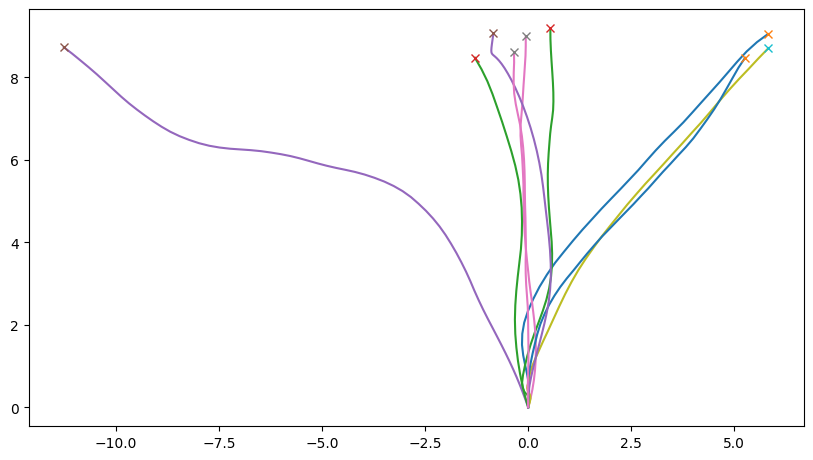

Processing scene #22
using min Y displacement (8)


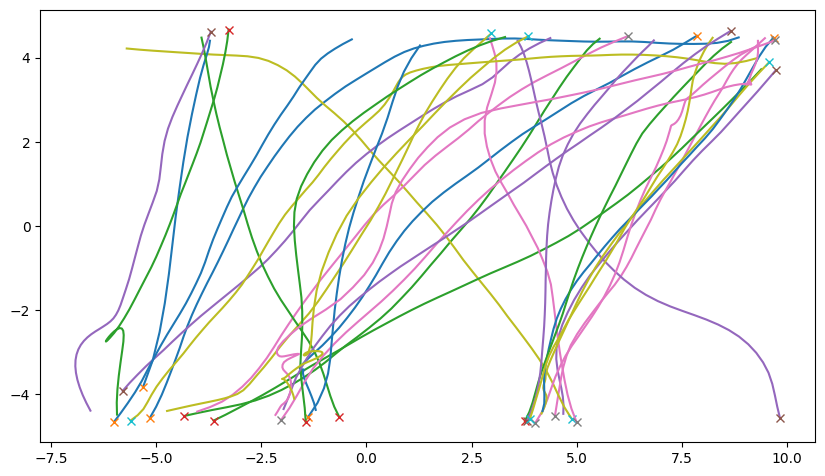

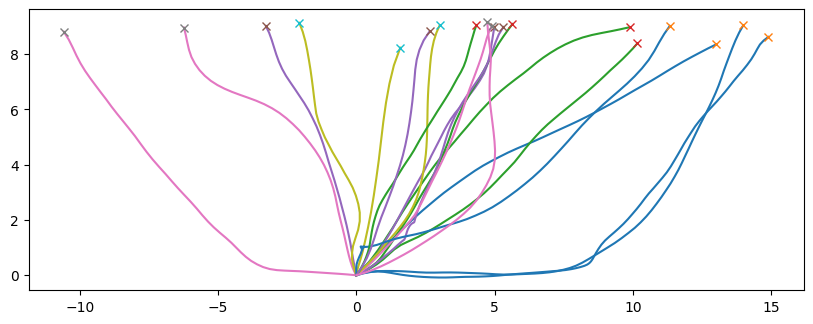

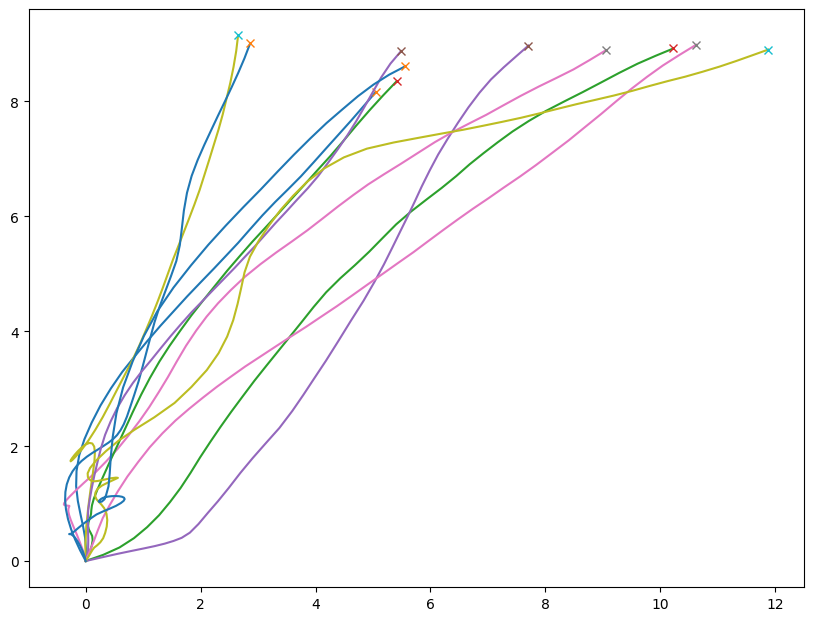

Processing scene #31
using min Y displacement (5)


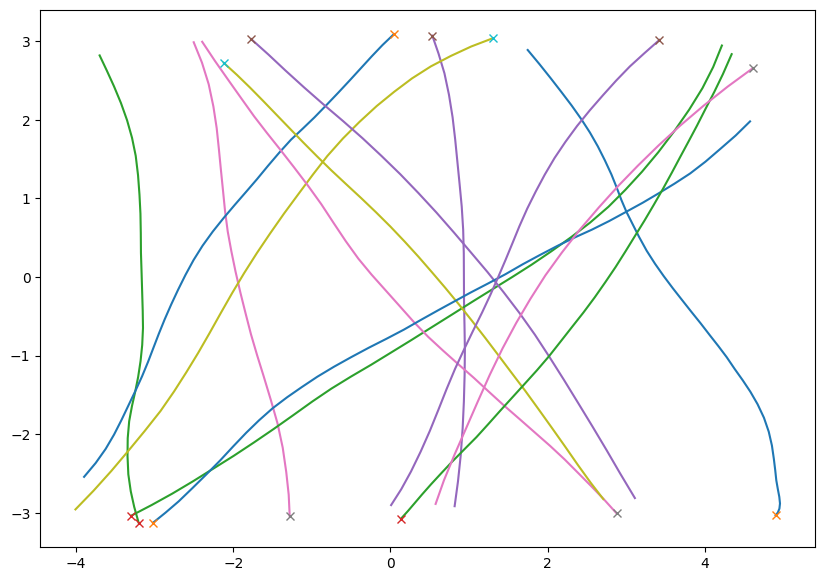

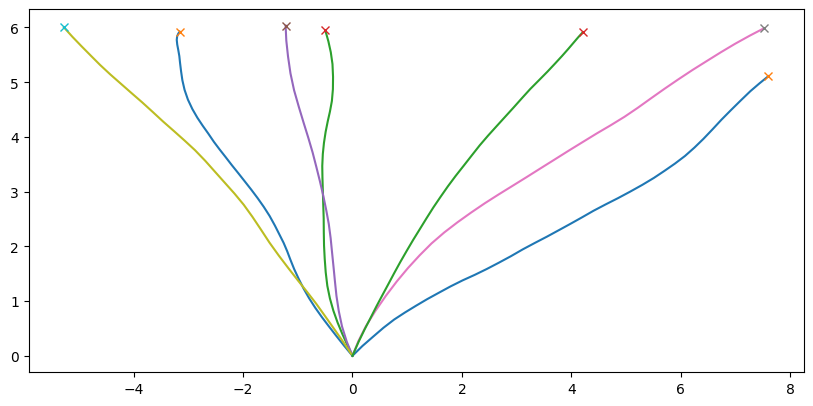

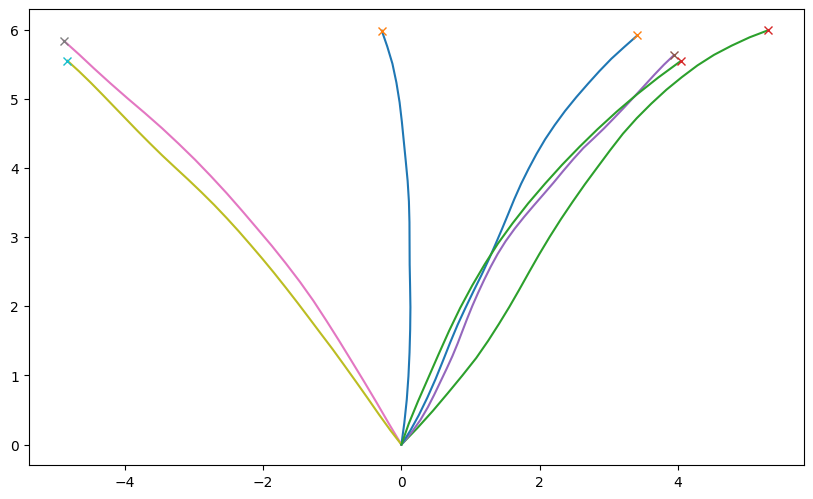

In [8]:
sceneData = {}
for sceneId in sceneDisplacementMap:
    print(f"Processing scene #{sceneId}")
    cleaner = TrajectoryCleaner(
        colMapper = colMapper,
        minSpeed = 0.0,
        maxSpeed = 3.5,
        minYDisplacement = sceneDisplacementMap[sceneId],
        maxXDisplacement = maxXDisplacement
    )
    pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
    otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
    tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))
    transformer.deriveSpeed(pedDf)
    transformer.deriveDisplacements(pedDf)
    
    cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
    visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
    
    allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
    transformer.translateAllToLocalSource(cleanPedDf)
    
    southIds = indTransformer.convertLocalToNorth(cleanPedDf, tracksMeta)
    # visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    southPeds = cleanPedDf[cleanPedDf["uniqueTrackId"].isin(southIds)]
    northPeds = cleanPedDf[~cleanPedDf["uniqueTrackId"].isin(southIds)]
    visualizer.show(southPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    visualizer.show(northPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    
    
    sceneData[sceneId] = {
        "cleanPedDf": cleanPedDf,
        "otherDf": otherDf,
        "meta": tracksMeta,
        "southPeds": southPeds,
        "northPeds": northPeds,
        
    }


Processing scene #21


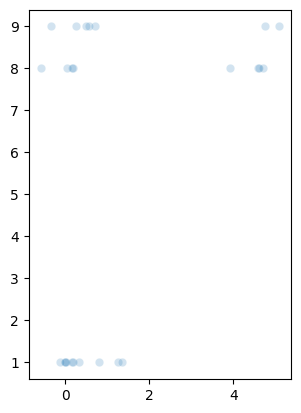

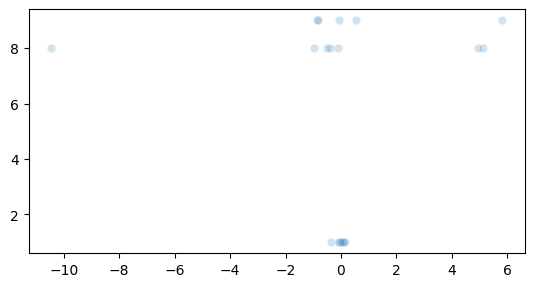

Processing scene #22


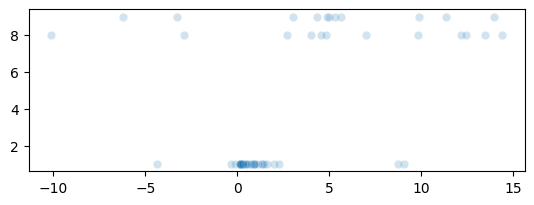

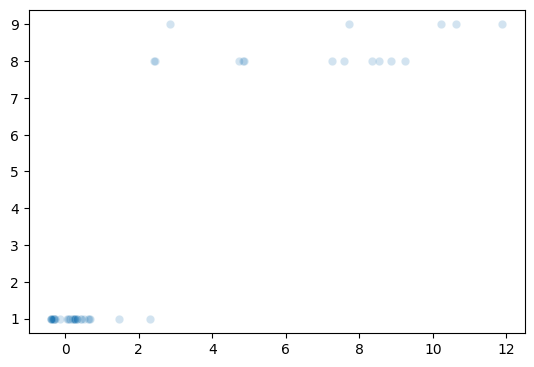

Processing scene #31


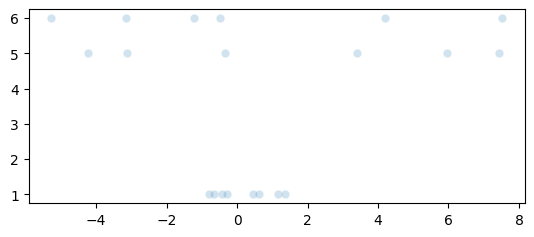

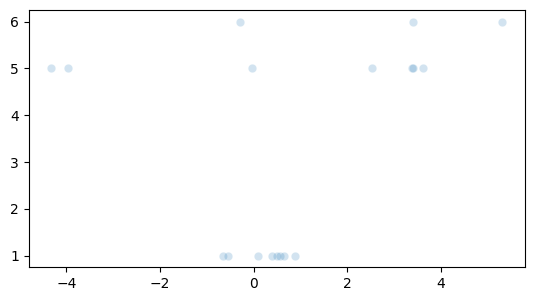

In [9]:
dividerY = 1
for sceneId in sceneDisplacementMap:
    print(f"Processing scene #{sceneId}")
    
    southPeds = sceneData[sceneId]["southPeds"]
    northPeds = sceneData[sceneId]["northPeds"]
    
    roadWidth = sceneRoadWidth[sceneId]
    interval = 1.0
    yTolerance = 0.1

    yBreakpoints = [dividerY, roadWidth - dividerY, roadWidth] # start, mid, end

    breakpointXVals = crosswalkModel.getAllLocalXAtLocalYBreakpoints(
            tracksDf = southPeds,
            yBreakpoints = yBreakpoints,
            yTolerance = yTolerance
        )
    visualizer.showBreakpointVals(breakpointXVals)
    
    minVals = [min(breakpointXVals[y]) for y in yBreakpoints]
    maxVals = [max(breakpointXVals[y]) for y in yBreakpoints]
    
    sceneData[sceneId]["southMinVals"] = minVals
    sceneData[sceneId]["southMaxVals"] = maxVals
    
    breakpointXVals = crosswalkModel.getAllLocalXAtLocalYBreakpoints(
            tracksDf = northPeds,
            yBreakpoints = yBreakpoints,
            yTolerance = yTolerance
        )
    visualizer.showBreakpointVals(breakpointXVals)
    
    minVals = [min(breakpointXVals[y]) for y in yBreakpoints]
    maxVals = [max(breakpointXVals[y]) for y in yBreakpoints]
    
    sceneData[sceneId]["northMinVals"] = minVals
    sceneData[sceneId]["northMaxVals"] = maxVals

In [10]:
for sceneId in sceneData:
    print(sceneData[sceneId]["southMinVals"], sceneData[sceneId]["southMaxVals"])
    print(sceneData[sceneId]["northMinVals"], sceneData[sceneId]["northMaxVals"])

[-0.129585179615189, -0.5879792139729014, -0.3402533398923655] [1.358461087278489, 4.715089027696976, 5.100490098656618]
[-0.3638431184388944, -10.455891178683716, -0.86292954919546] [0.1536797741631144, 5.109555801550962, 5.813317199574808]
[-4.347319904232792, -10.117955036931118, -6.231324769641795] [9.091815148180578, 14.401918086600938, 13.990869883272524]
[-0.38116949581736037, 2.419264495109821, 2.861207502114833] [2.3021494763426897, 9.239488637295233, 11.88188843640271]
[-0.7919863472297037, -4.233168951454322, -5.274239171209637] [1.3657948337655528, 7.4383335061890525, 7.519941221506867]
[-0.6568463196129346, -4.3270899167809205, -0.28360900223597596] [0.8803947625711266, 3.6150390896383415, 5.3094310220587575]
